# Redes LSTM y bandas de confianza

## Juan Diego Ariza

Cargar paquetes necesarios

In [32]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import pandas as pd
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
#from tensorflow import keras
#
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, Dropout
from tensorflow.keras.models import Model
#
from tensorflow.keras.optimizers import Adam
#
from tensorflow.keras.utils import plot_model
#
from sklearn.preprocessing import MinMaxScaler
#
print("Versión de Tensorflow: ", tf.__version__)

Versión de Tensorflow:  2.3.0


In [33]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
#
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
#

#tf.random.set_seed(RANDOM_SEED)
#

Simulamos unos datos 

In [34]:
#
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
trend = .1
#
time = np.arange(0, 100, 0.1)
sin =  trend*time + np.sin(time) + np.random.normal(scale=0.5, size=len(time))

Hacemos el gráfico de la serie de tiempo

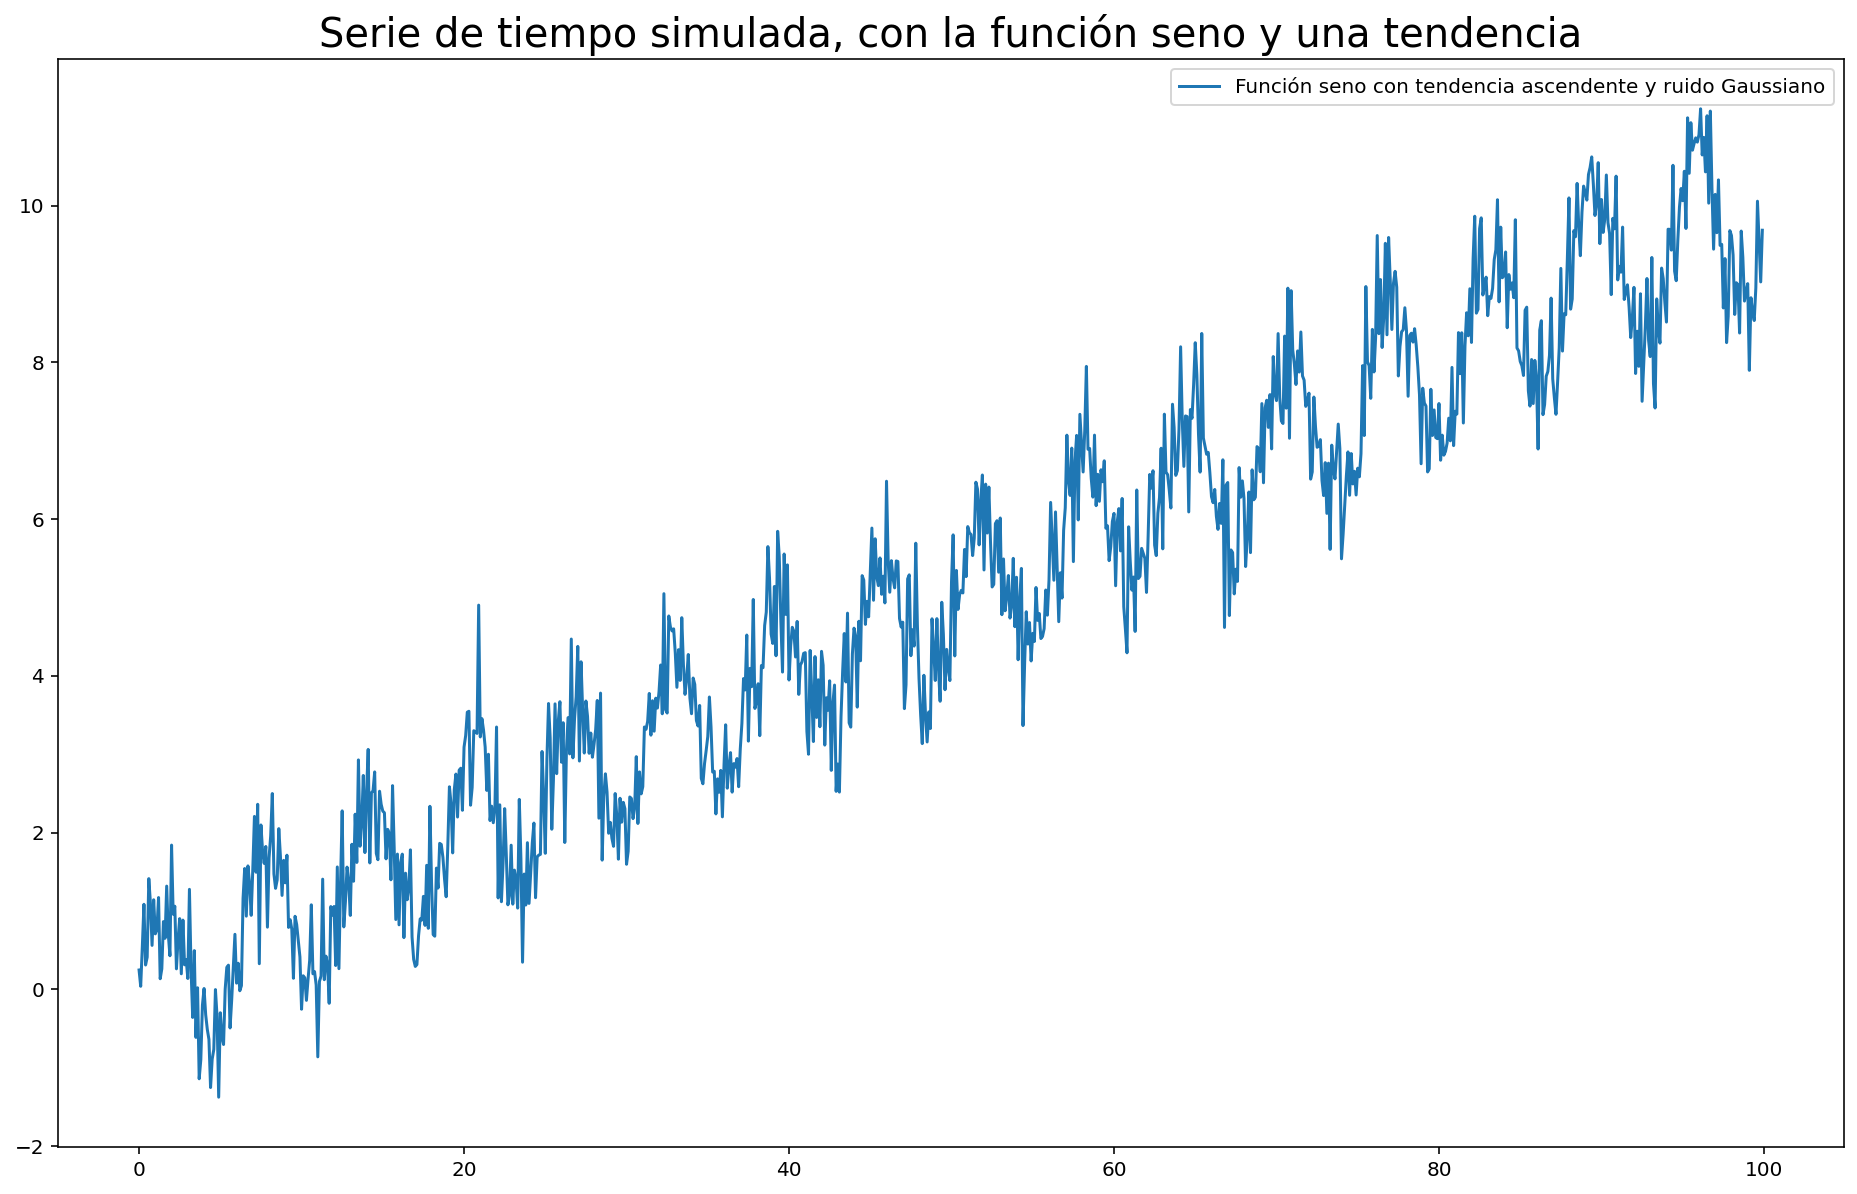

In [35]:
plt.plot(time, sin, label='Función seno con tendencia ascendente y ruido Gaussiano');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()

In [36]:
print('Número de datos', sin.shape[0])

Número de datos 1000


## Preprocesamiento de los datos

### Escala los datos

In [37]:
#crea un dataset 
#
df1 = pd.DataFrame(sin, index=time, columns=['serie'])
# crea el objeto  scaler y escala los datos
scaler = MinMaxScaler(feature_range=(0, 1)) #¿para que es esto?
scaled_data = scaler.fit_transform(df1.values)
#
dataset = pd.DataFrame(scaled_data,index=df1.index, columns=['serie'])
#

In [38]:
dataset.shape

(1000, 1)

grafico de datos escalados

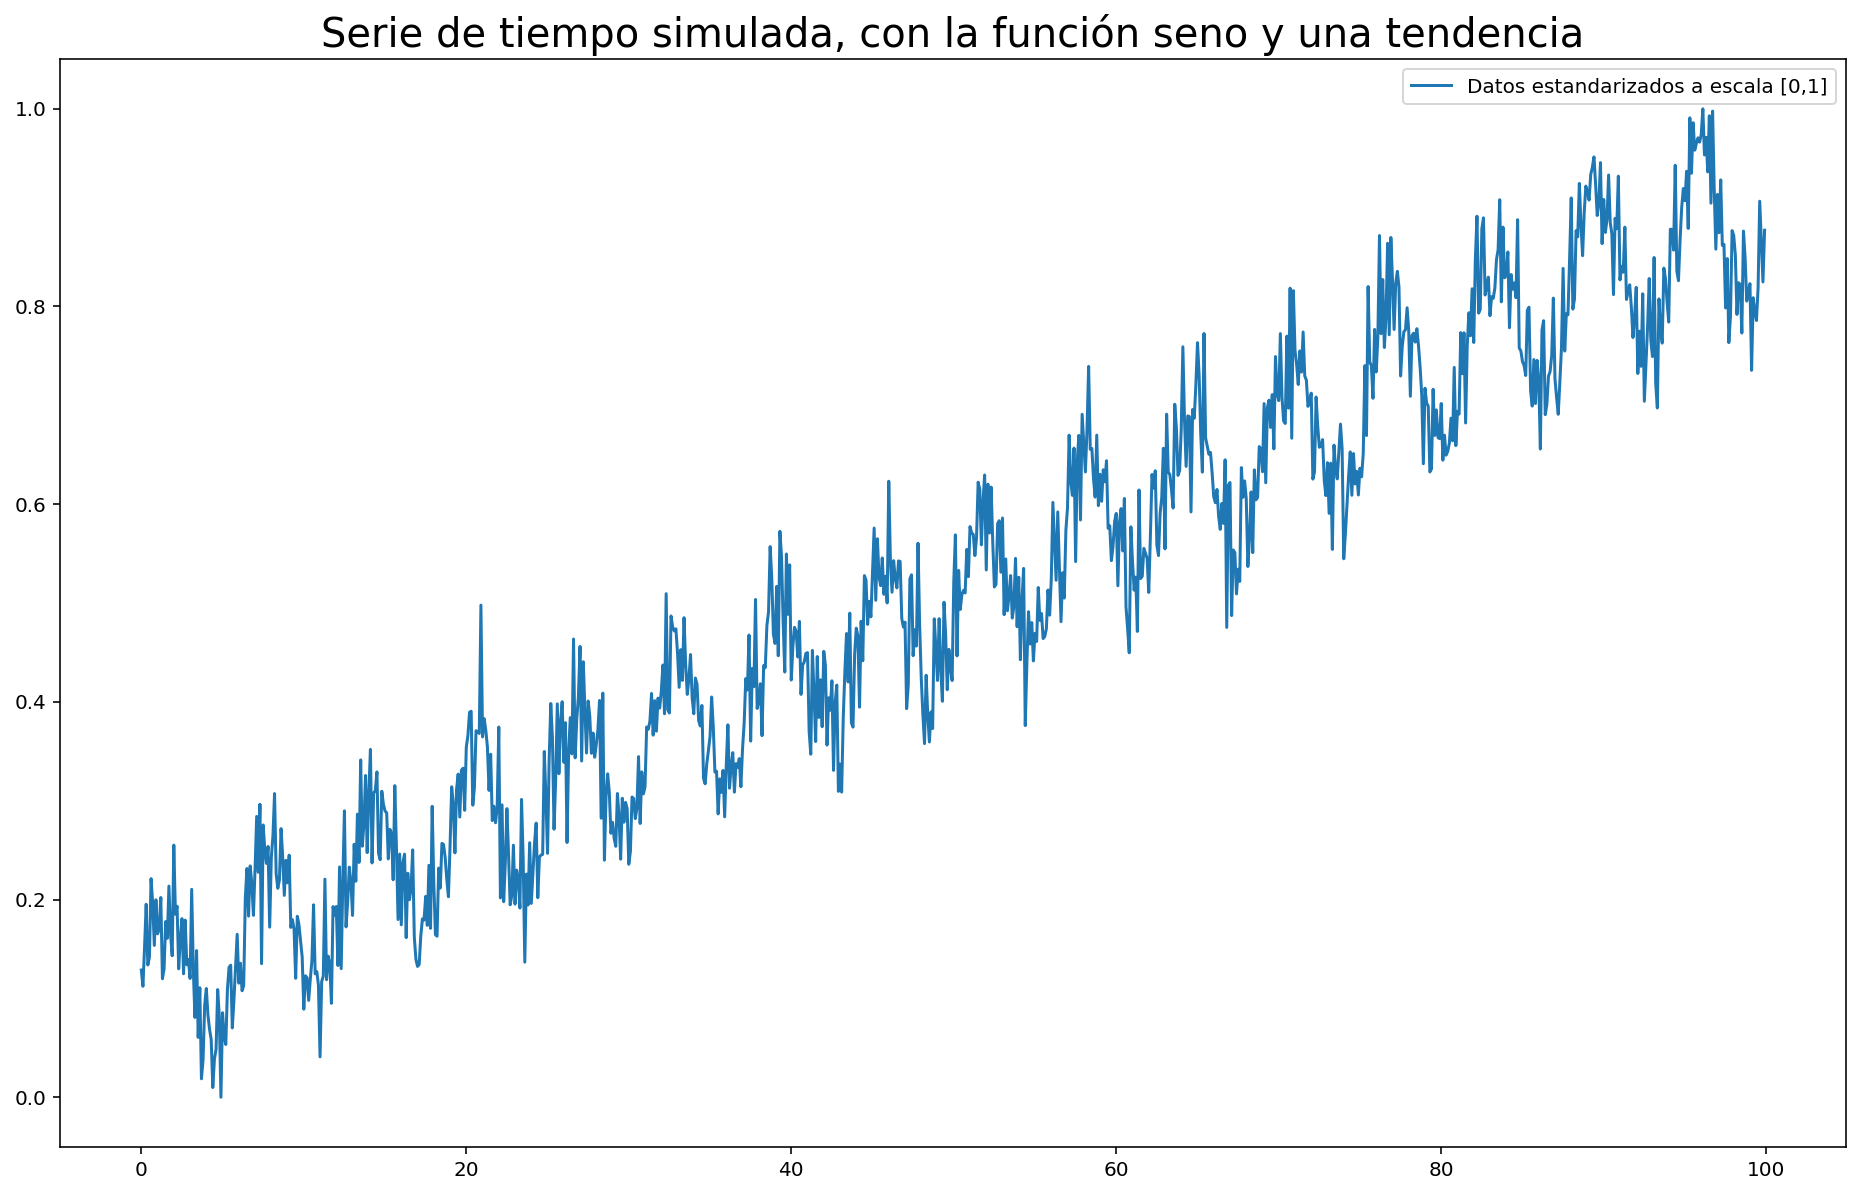

In [39]:
#serie_0_1 = dataset.serie_0_1.values

plt.plot(time, dataset, label='Datos estandarizados a escala [0,1]');
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend();
plt.show()

### Separacion de datos de entrenamiento y de validación

In [40]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(df1)]
len_train = len(train)
len_test = len(test)
print(len_train, len_test)

800 200


In [41]:
train.shape

(800, 1)

grafico de la distinción entre datos de entrenamiento y validación

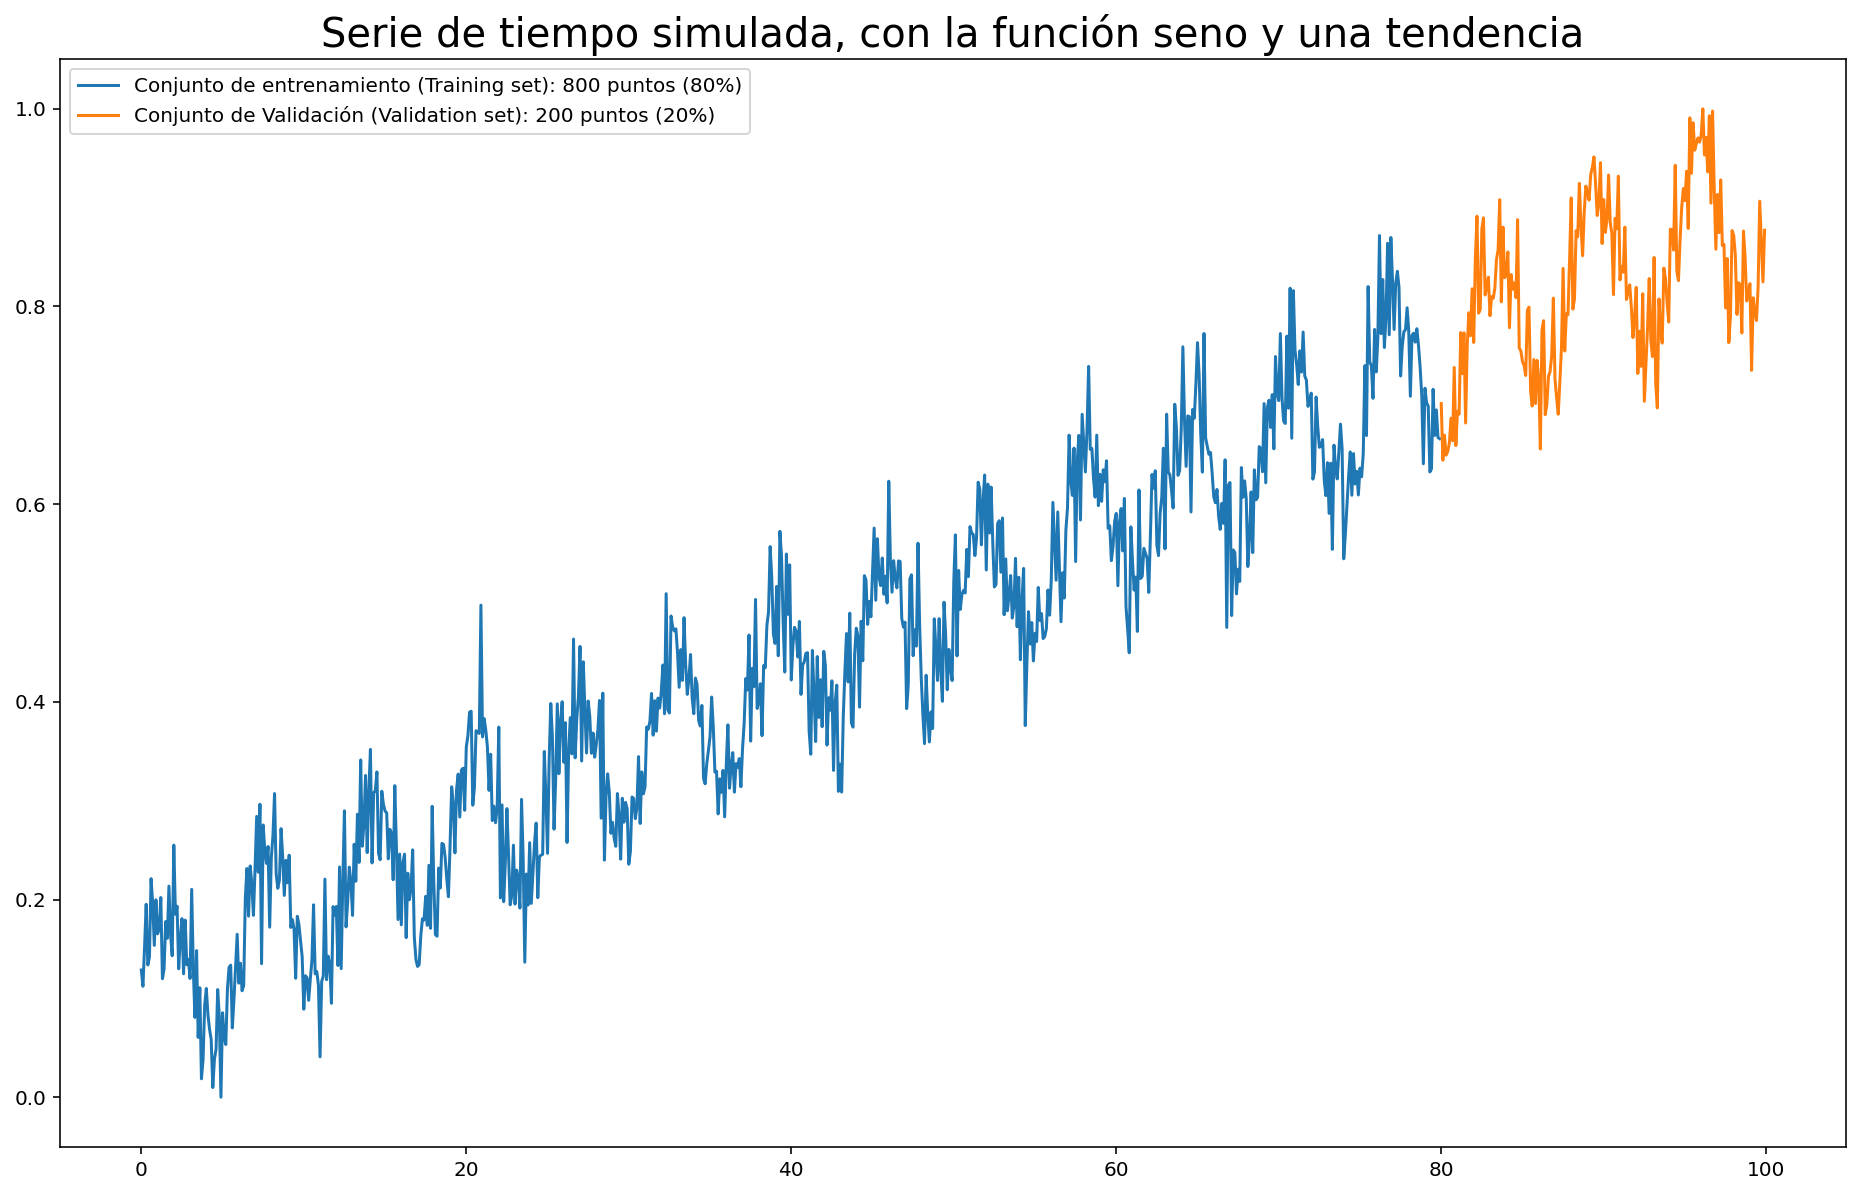

In [42]:
#plt.figure(figsize=(16,8))
plt.plot(train, label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (80%)')
plt.plot(test, label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (20%)') 
plt.title("Serie de tiempo simulada, con la función seno y una tendencia", size = 20)
plt.legend()
plt.show()

función para la predicción de los datos de series, predice el valor en el paso de tiempo actual utilizando el historial.

In [43]:
def create_dataset(X, y, time_steps=1):
    # crea dos listas vacias para depositar los datos
    Xs, ys = [], []
    # el primer lote de datos empieza en la primera observación
    # y toma time_steps  datos.
    # Comienza a avanzar hacia adelante.
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Vamos a conservar la historia de 50 pasos atrás para predecir el valor actual

In [44]:
time_steps = 50

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

print(X_train.shape, y_train.shape)

print([X_train[0:2,], y_train[0:2]])

(750, 50, 1) (750, 1)
[array([[[0.12866229],
        [0.1121937 ],
        [0.15199099],
        [0.19517542],
        [0.13373672],
        [0.14166865],
        [0.2211258 ],
        [0.19603986],
        [0.15358548],
        [0.19974127],
        [0.16525499],
        [0.16990083],
        [0.20199465],
        [0.11982438],
        [0.12982285],
        [0.17767362],
        [0.16076588],
        [0.21355511],
        [0.16446774],
        [0.14307962],
        [0.25505916],
        [0.1851261 ],
        [0.19321062],
        [0.12984983],
        [0.15998183],
        [0.18065415],
        [0.12482759],
        [0.17917075],
        [0.13392128],
        [0.13937234],
        [0.12008995],
        [0.21029807],
        [0.12917938],
        [0.0806848 ],
        [0.14828083],
        [0.0604929 ],
        [0.11070353],
        [0.01858177],
        [0.03791053],
        [0.09315708],
        [0.10995165],
        [0.08338189],
        [0.06856677],
        [0.05846956],
        [

## Modelo LSTM

### Creamos el modelo

In [45]:
# shapes
inputs_shape = (X_train.shape[1], X_train.shape[2])
lstm_output = 60

# layers
inputs = Input(inputs_shape)
x = LSTM(units=lstm_output, name='LSTM_layer')(inputs)
y = Dropout(0.2)(x)
outputs = Dense(1)(y)

# model
serie_0_1_model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')

summary del modelo

In [46]:
#model = keras.Sequential()
#model.add(keras.layers.LSTM(units=lstm_output,  input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(keras.layers.Dense(units=1))
serie_0_1_model.summary()

plot_model(serie_0_1_model, to_file='../Imagenes/series_LSTM_model.png', 
           show_shapes=True)

Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 60)                14880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


El calculo de neuronas es $4(p^2 + pn + p)$ donde p es el tamaño de salida y n el tamaño de entrada

In [47]:
lstm_output =60  ## p 
input_size =1 # input size in the LSTM machine (n)
#
# cada entrada de tamaño 50 es mostrada a la máquina  LSTM machine uno por uno.
# luego se tiene
#
num_params = 4*(lstm_output*lstm_output + lstm_output*input_size+ lstm_output)
num_params

14880

### Compila

In [48]:
serie_0_1_model.compile(loss='mean_squared_error',
  optimizer=Adam(0.001)
)

## Entrenamiento

In [49]:
history = serie_0_1_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)


Epoch 1/30
43/43 [==============================] - 2s 41ms/step - loss: 0.0121 - val_loss: 0.0037
Epoch 2/30
43/43 [==============================] - 1s 27ms/step - loss: 0.0070 - val_loss: 0.0028
Epoch 3/30
43/43 [==============================] - 1s 27ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 4/30
43/43 [==============================] - 1s 26ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 5/30
43/43 [==============================] - 1s 28ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 6/30
43/43 [==============================] - 1s 27ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 7/30
43/43 [==============================] - 1s 28ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 8/30
43/43 [==============================] - 1s 29ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 9/30
43/43 [==============================] - 1s 28ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 10/30
43/43 [==============================] - 1s 27ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 11/

## Evaluacion del modelo

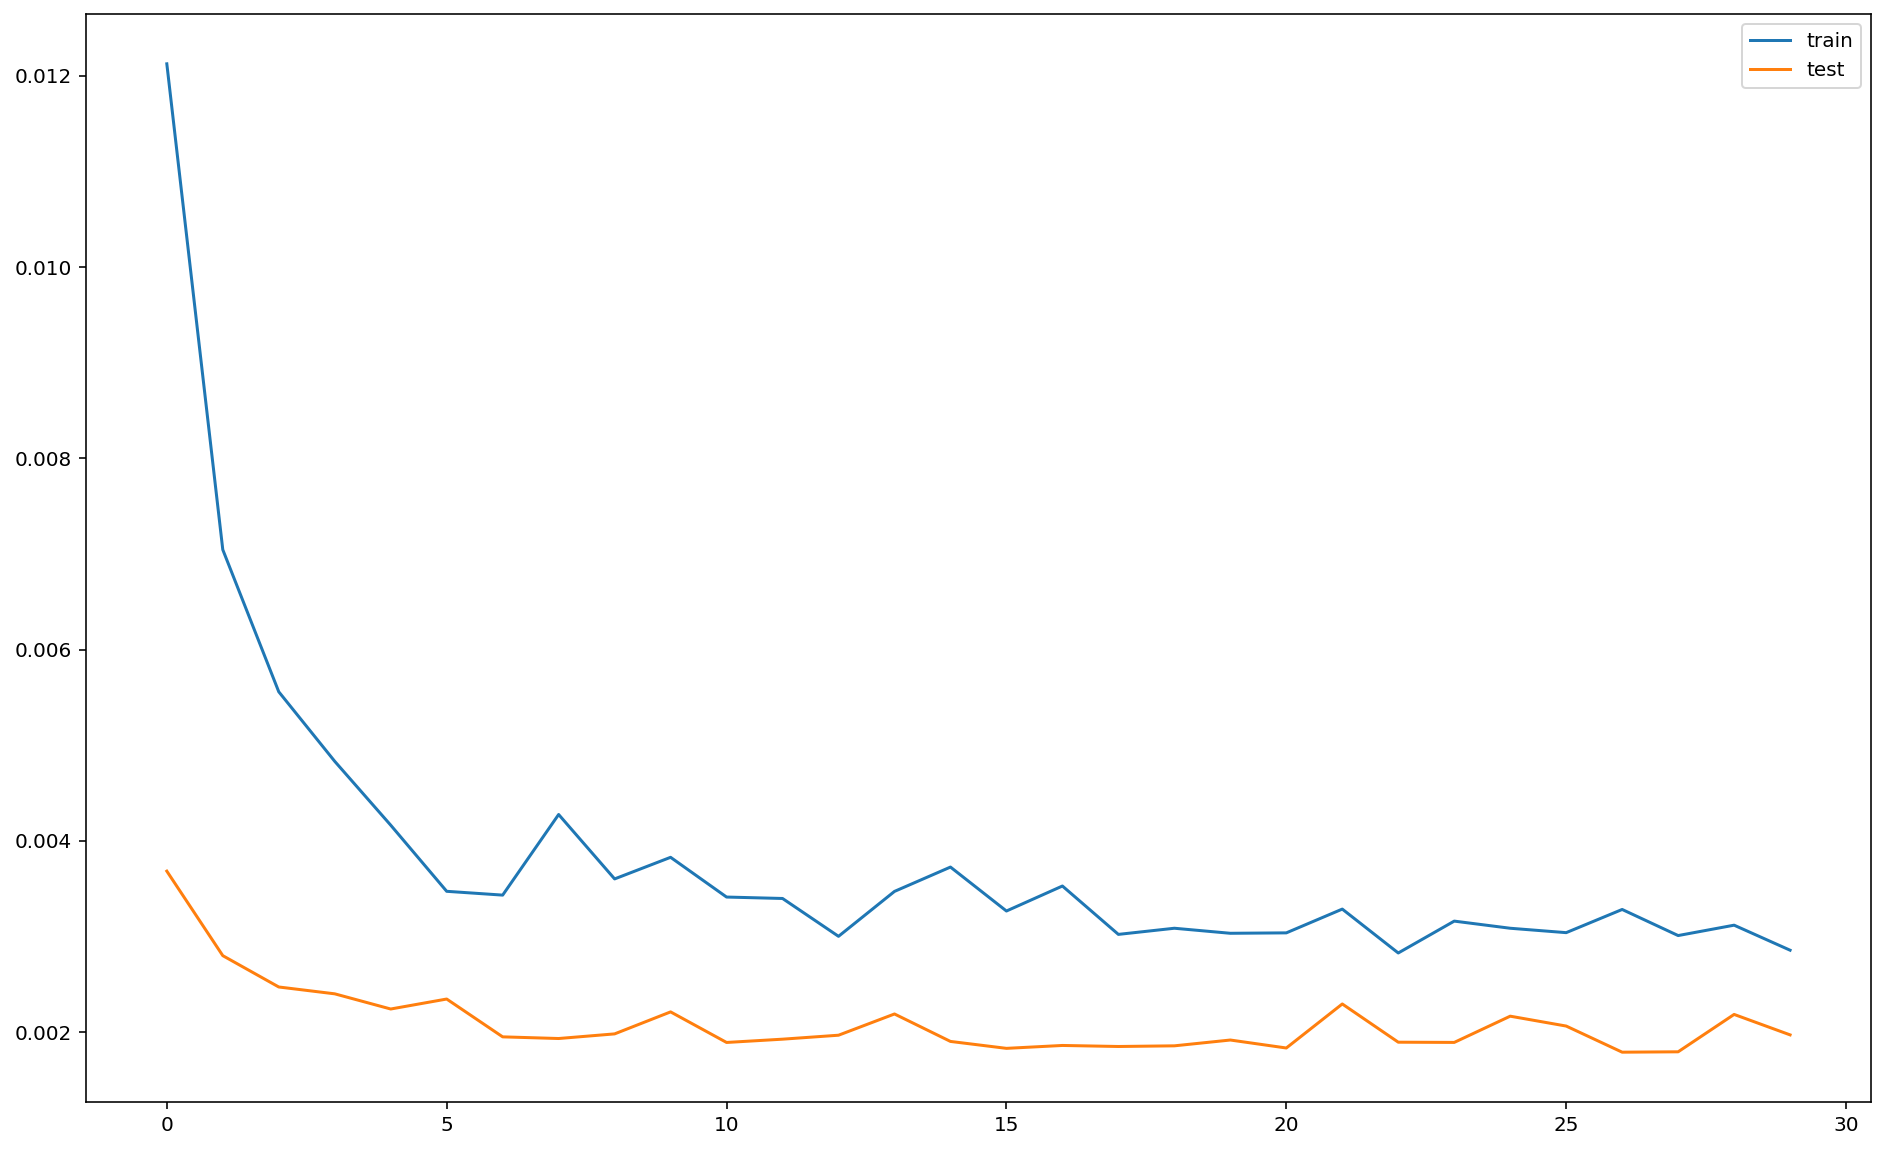

In [50]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [51]:
y_pred =serie_0_1_model.predict(X_test)

Datos predecidos

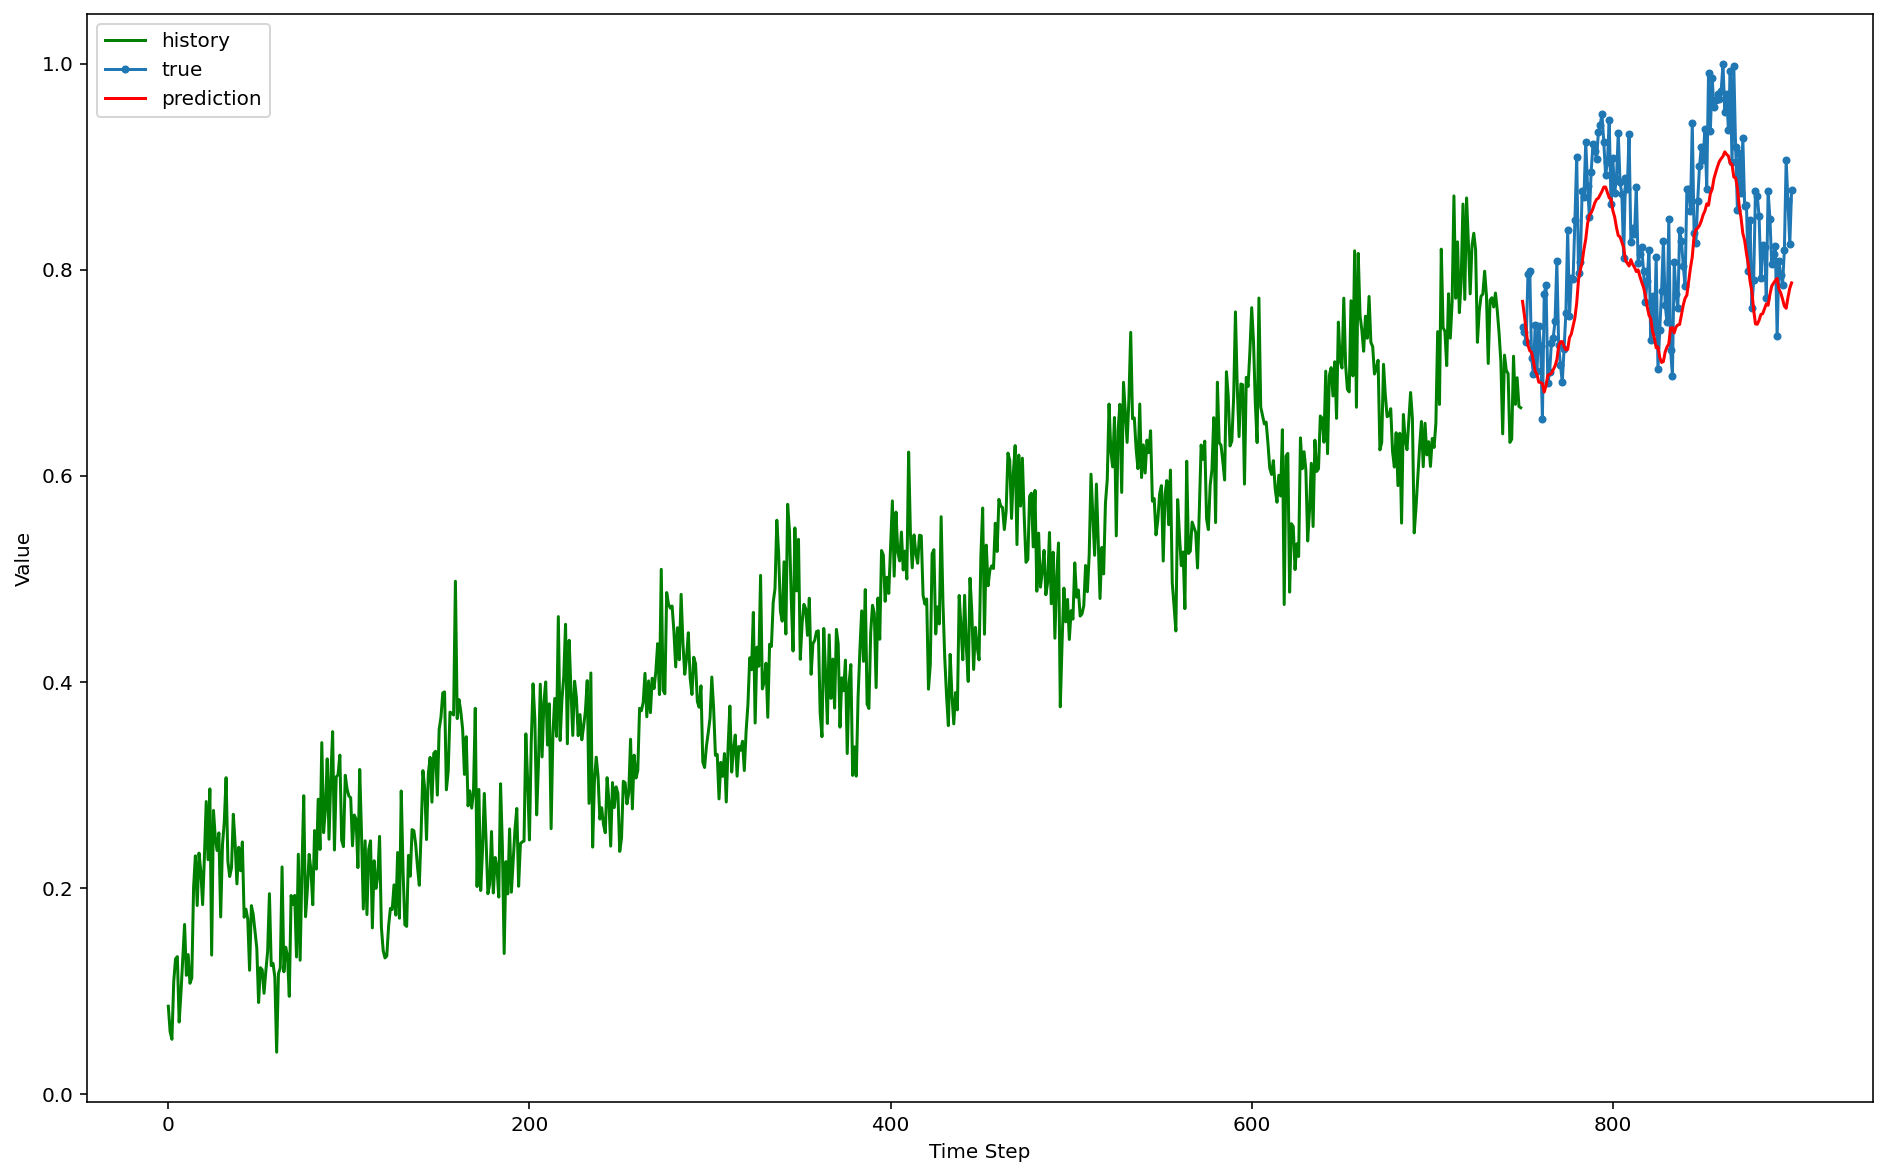

In [52]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

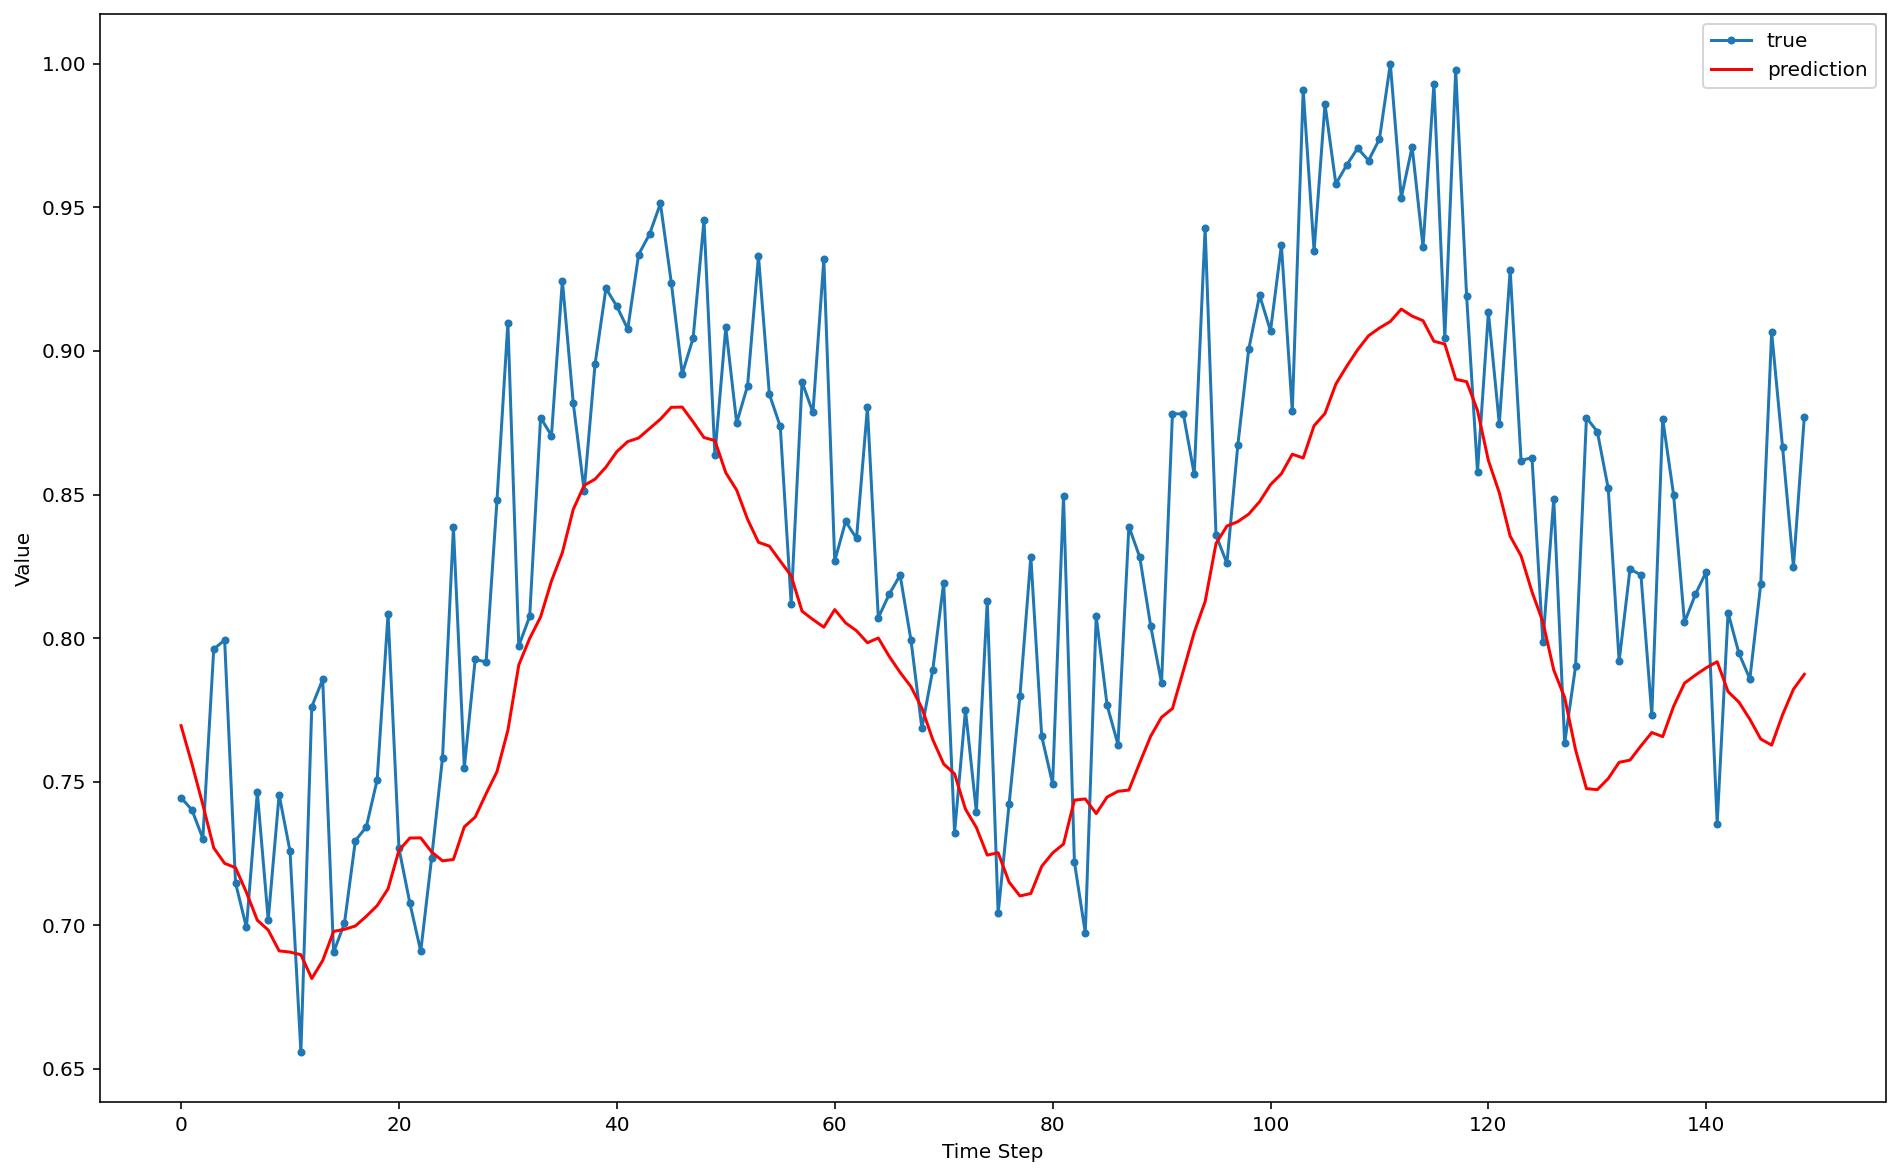

In [53]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

### Transforma a la escala original

In [62]:
scaled_data = scaler.fit_transform(df1.values)
dataset = pd.DataFrame(scaled_data)
dataset.columns = ['sine']
dataset.index = df1.index
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
y_test.shape

(150, 1)

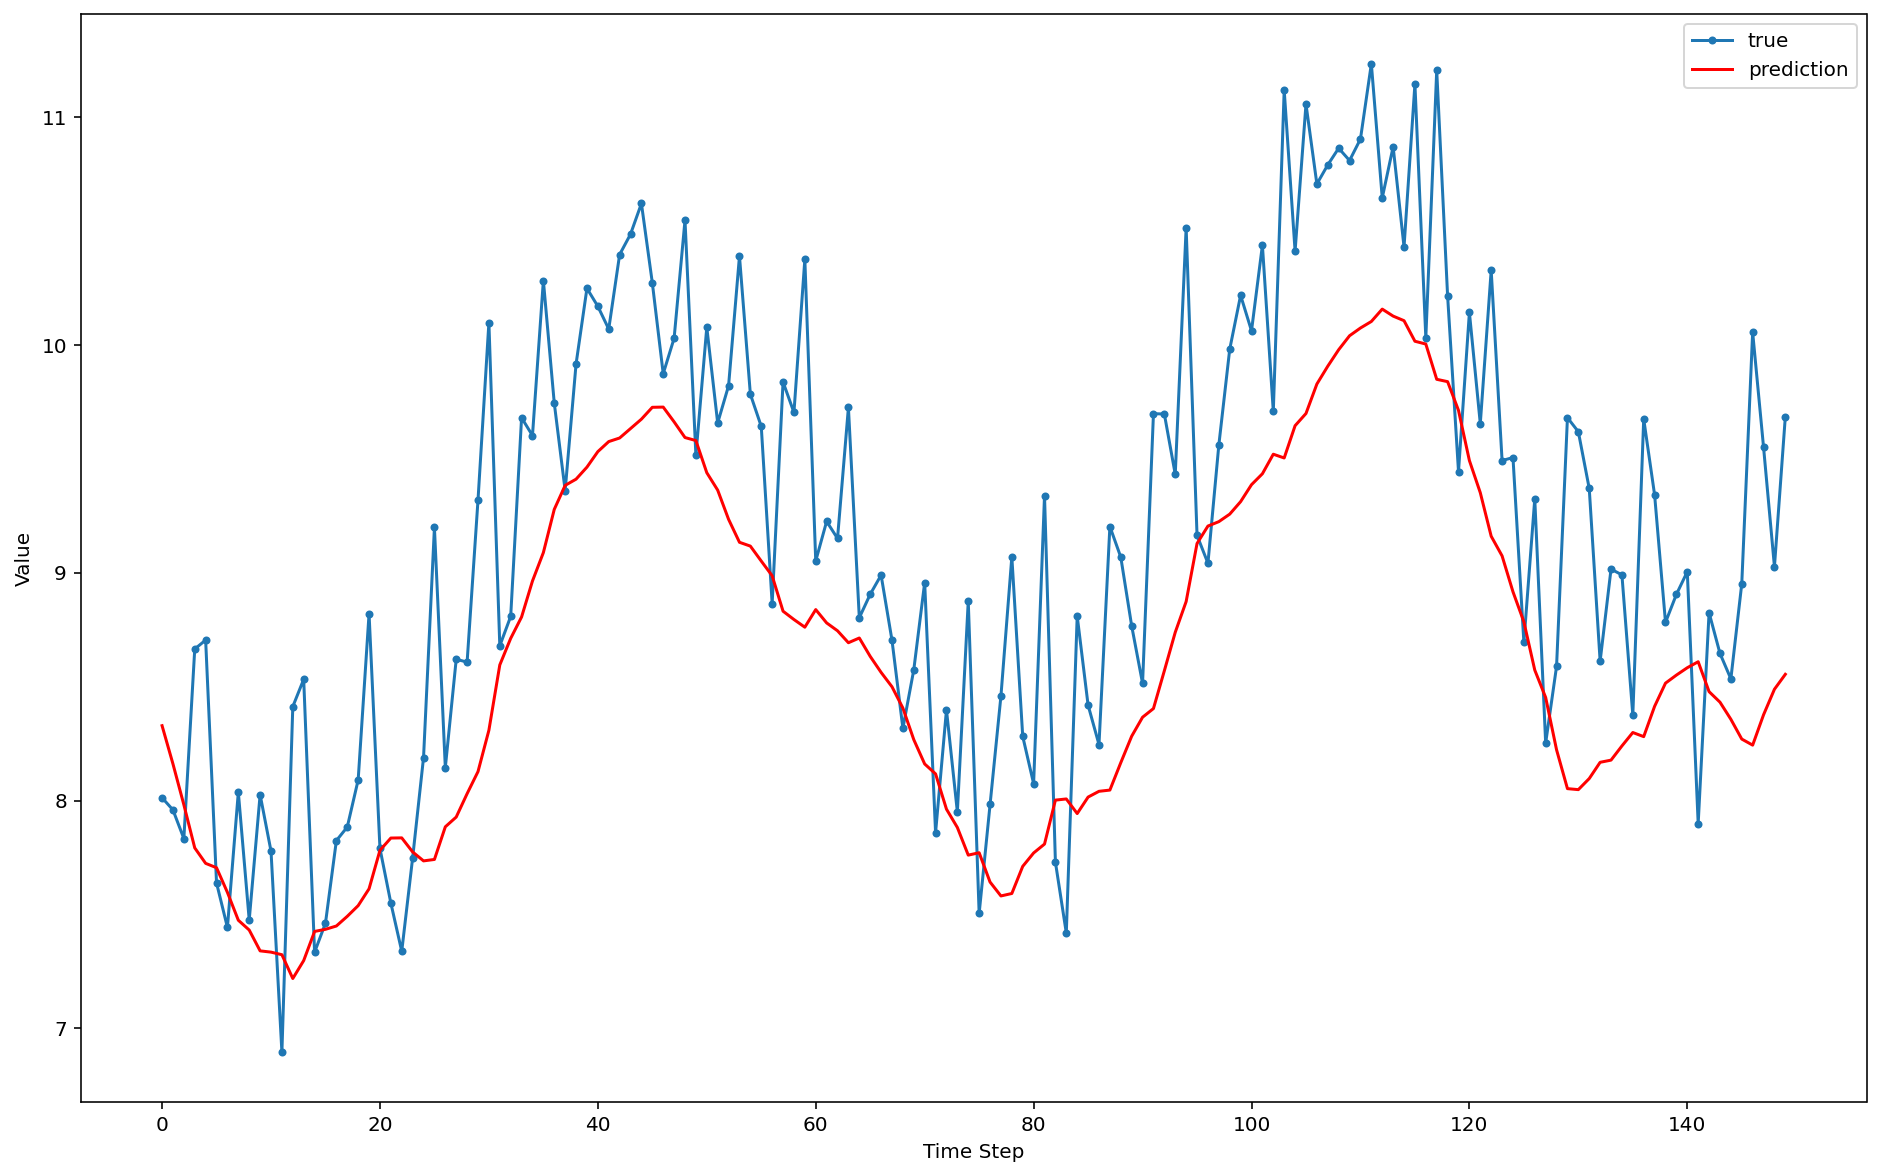

In [63]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Bandas de confianza

In [25]:
from keras.models import Model, Sequential
from keras import backend as K

def create_dropout_predict_function(model, dropout):
    """
    Create a keras function to predict with dropout
    model : keras model
    dropout : fraction dropout to apply to all layers
    
    Returns
    predict_with_dropout : keras function for predicting with dropout
    """
    
    # Load the config of the original model
    conf = model.get_config()
    # Add the specified dropout to all layers
    for layer in conf['layers']:
        # Dropout layers
        if layer["class_name"]=="Dropout":
            layer["config"]["rate"] = dropout
        # Recurrent layers with dropout
        elif "dropout" in layer["config"].keys():
            layer["config"]["dropout"] = dropout

    # Create a new model with specified dropout
    if type(model)==Sequential:
        # Sequential
        model_dropout = Sequential.from_config(conf)
    else:
        # Functional
        model_dropout = Model.from_config(conf)
    model_dropout.set_weights(model.get_weights()) 
    
    # Create a function to predict with the dropout on
    predict_with_dropout = K.function(model_dropout.inputs, model_dropout.outputs)
    
    return predict_with_dropout

In [59]:
import numpy as np
from keras.models import load_model

dropout = 0.5
num_iter = 20
num_samples = 750

#path_to_model = "model_LSTM.hdf5"
#model1 = load_model("model_LSTM.hdf5")

predict_with_dropout = create_dropout_predict_function(serie_0_1_model , dropout)

predictions = np.zeros((num_samples, num_iter))
for i in range(num_iter):
    predictions[:,i] = predict_with_dropout(X_train+[1])[0].reshape(-1)

In [83]:
ci = 0.95
lower_lim = np.quantile(predictions, 0.5-ci/2, axis=1)
upper_lim = np.quantile(predictions, 0.5+ci/2, axis=1)

In [84]:
lower_lim = scaler.inverse_transform(lower_lim.reshape(-1,1)) 
upper_lim = scaler.inverse_transform(upper_lim.reshape(-1,1)) 
upper_lim.shape

(750, 1)

In [85]:
lower_lim[0:150]

array([[7.44202235],
       [7.52735607],
       [7.56893579],
       [7.59853327],
       [7.71128342],
       [7.86253788],
       [8.02289306],
       [8.07386963],
       [8.14502278],
       [8.24185849],
       [8.37603283],
       [8.42040236],
       [8.47772742],
       [8.46452539],
       [8.43758019],
       [8.53466918],
       [8.68037857],
       [8.75888731],
       [8.91426938],
       [9.02892099],
       [9.0748568 ],
       [9.16747246],
       [9.32333102],
       [9.37482692],
       [9.52245732],
       [9.38214568],
       [9.44107008],
       [9.42868875],
       [9.39077368],
       [9.37324562],
       [9.21542848],
       [9.16513809],
       [9.14574164],
       [9.21412977],
       [9.17145877],
       [9.11371284],
       [9.0645017 ],
       [9.09711672],
       [9.09423672],
       [9.03761062],
       [9.03748736],
       [8.99936786],
       [9.01198668],
       [8.90959463],
       [8.82046474],
       [8.71121839],
       [8.52353846],
       [8.442

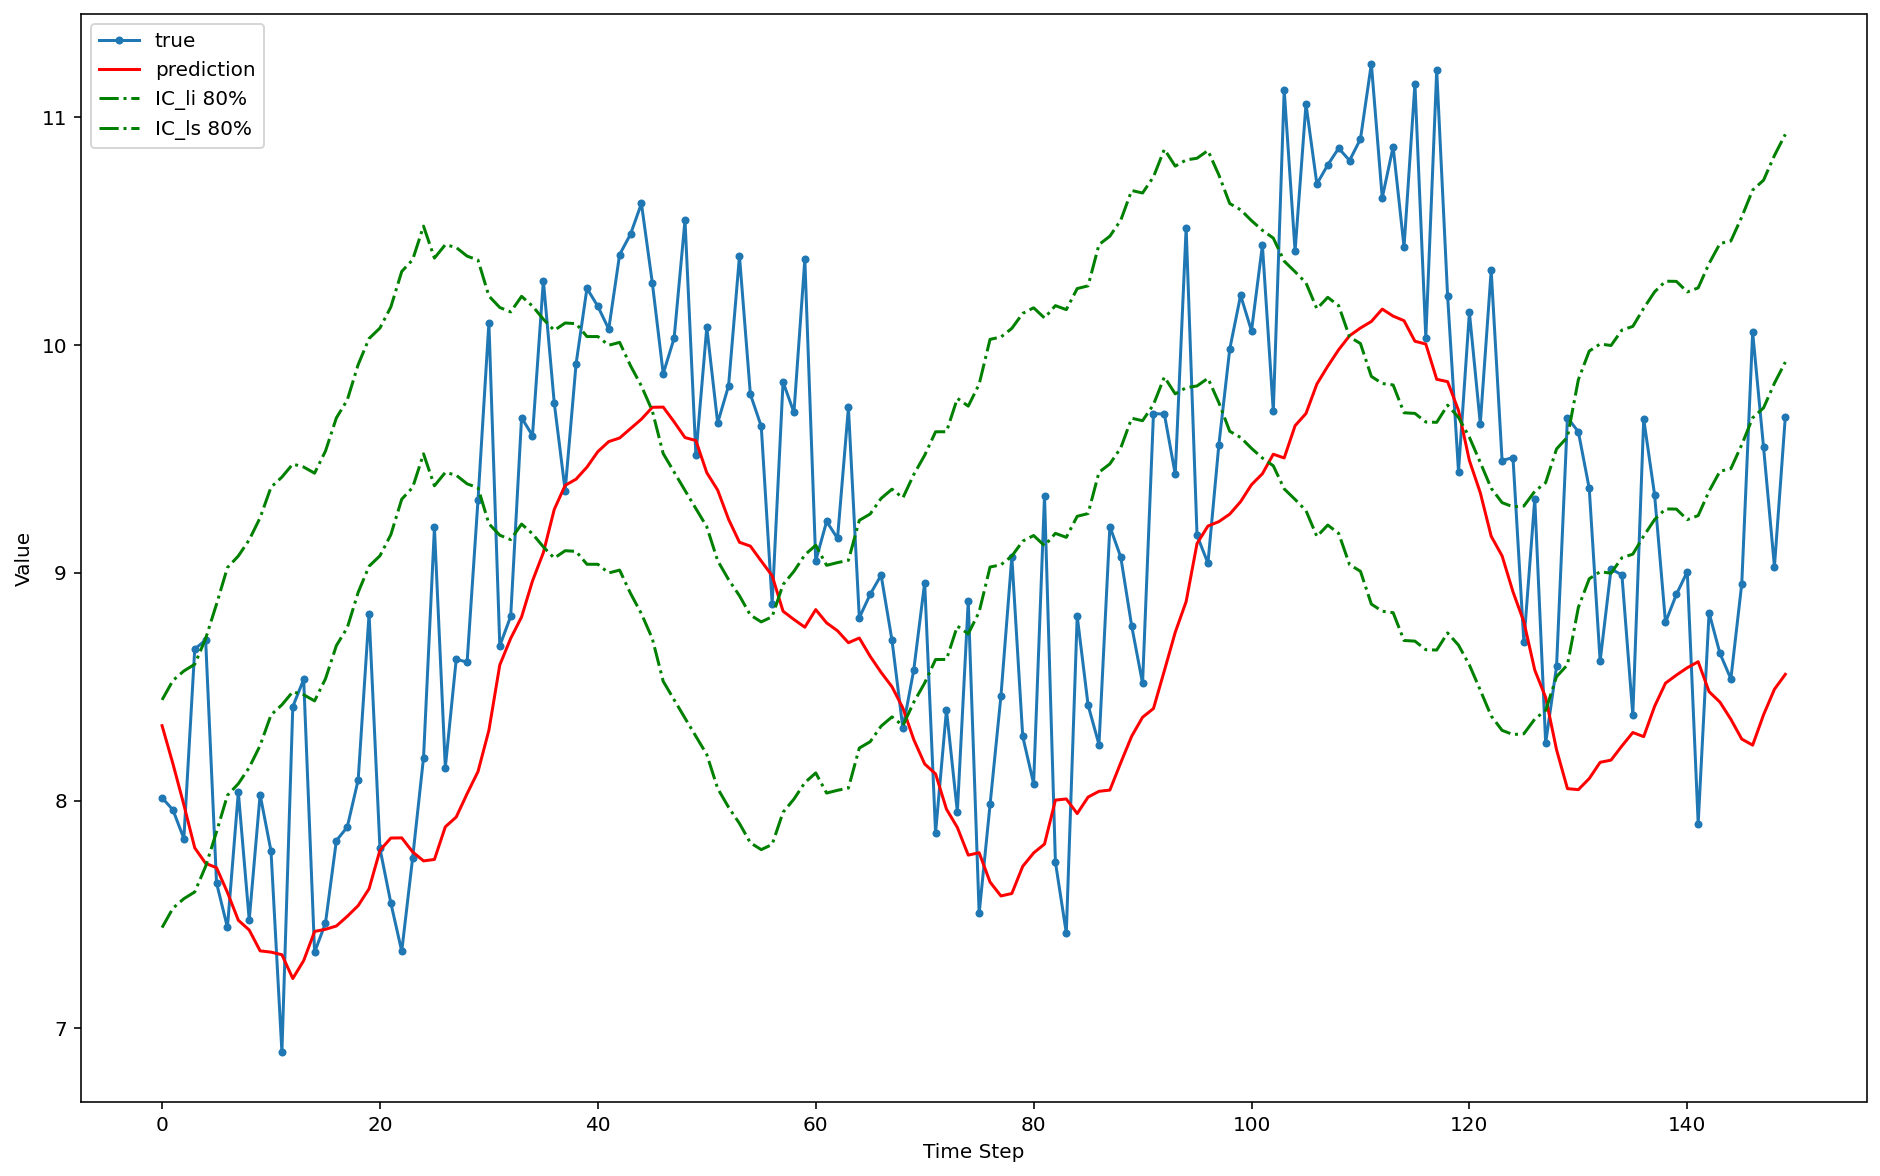

In [88]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.plot(lower_lim[0:150], 'g', label='IC_li 80%', linestyle="-.")
plt.plot(upper_lim[0:150], 'g', label='IC_ls 80%', linestyle="-.")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();